In [1]:
import pandas as pd

In [2]:
twit_df = pd.read_csv("0000000000002747_training_twitter_x_y_train.csv")

In [3]:
twit_df.head()

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567900433542488064,negative,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada)
1,569989168903819264,positive,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)
2,568089179520954368,positive,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada)
3,568928195581513728,negative,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada)
4,568594180014014464,negative,United,NaN,J_Okayy,NaN,0,@united so our flight into ORD was delayed bec...,NaN,2015-02-19 18:13:11 -0800,NaN,Eastern Time (US & Canada)


In [4]:
twit_df.shape

(10980, 12)

In [5]:
print(twit_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10980 entries, 0 to 10979
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   tweet_id                10980 non-null  int64 
 1   airline_sentiment       10980 non-null  object
 2   airline                 10980 non-null  object
 3   airline_sentiment_gold  31 non-null     object
 4   name                    10980 non-null  object
 5   negativereason_gold     24 non-null     object
 6   retweet_count           10980 non-null  int64 
 7   text                    10980 non-null  object
 8   tweet_coord             776 non-null    object
 9   tweet_created           10980 non-null  object
 10  tweet_location          7430 non-null   object
 11  user_timezone           7403 non-null   object
dtypes: int64(2), object(10)
memory usage: 1.0+ MB
None


In [6]:
import string
punc=string.punctuation

In [7]:
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

Cleaning and forming vocablary

In [8]:
abbreviations = {'ppl': 'people','cust':'customer','serv':'service','mins':'minutes','hrs':'hours','svc': 'service',
           'u':'you','pls':'please','thanks':'thank'}
stop = set(stopwords.words('english')+list(punctuation)+['flight','airline','flights','aa'])
punc= punctuation

In [9]:
def convert_abv(x):
    if(x in abbreviations):
        return abbreviations[x]
    return x

In [10]:
def pos_wnet(word):
    if (word.startswith('N')):
        return wordnet.NOUN
    elif word.startswith('J'):
        return wordnet.ADJ
    elif word.startswith('R'):
        return wordnet.ADV
    elif word.startswith('V'):
        return wordnet.VERB
    else:
        return wordnet.NOUN



In [11]:
def clean1(tweet):
    tweet=tweet.lower()
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) #remove links
    tweet = re.sub('@[^\s]+','',tweet) #remove usernames
    tweet=re.sub(r'[^\w\s]', r' ', tweet)
    tweet = re.sub('[\s]+', ' ', tweet) #remove additional whitespaces
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) #replace #word with word
    tweet= re.sub('[0-9]+','',tweet)
   

    tweet=re.sub('thanks','thank',tweet)
    tweet = tweet.strip('\'"') #trim tweet
    tweet.encode('ascii', 'ignore').decode('ascii')
    l_w = (word_tokenize(tweet))
    words= pos_tag(l_w)
    lemma= WordNetLemmatizer()
    op=[convert_abv(lemma.lemmatize(w[0],pos_wnet(w[1]))) for w in words if w[0] not in stop ]
    
    return " ".join(op)

In [12]:
twit_df.text=twit_df.text.apply(clean1)
train_index = twit_df[~twit_df.negativereason_gold.isna()].index

for index, row in twit_df.iterrows():
    row.text = " %s %s" % (row.text, row.airline)
    if index in train_index:
        row.text = " %s %s" % (row.text, row.negativereason_gold)
        

Visualization

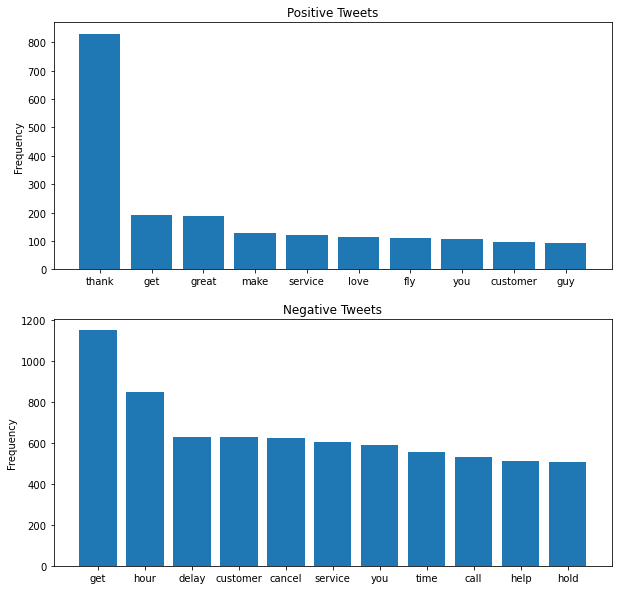

In [14]:
positive=[]
for twit in twit_df['text'][twit_df.airline_sentiment=='positive']:
    positive+=twit.split()
negative=[]
for twit in twit_df['text'][twit_df.airline_sentiment=='negative']:
    negative+=twit.split()

freq_pos= nltk.FreqDist(positive)
pos_word=[word[0] for word in freq_pos.most_common(10)]
pos_freq=[word[1] for word in freq_pos.most_common(10)] 
freq_neg= nltk.FreqDist(negative)
neg_word=[word[0] for word in freq_neg.most_common(11)]
neg_freq=[word[1] for word in freq_neg.most_common(11)] 
fig= plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.bar(pos_word,pos_freq)
plt.ylabel('Frequency')
plt.title('Positive Tweets')
plt.subplot(2,1,2)
plt.bar(neg_word,neg_freq)
plt.ylabel('Frequency')
plt.title('Negative Tweets')
plt.savefig('plots_tweeets.png')
plt.show()


#Multinomial Naive Bayes

In [561]:
X=twit_df.text
Y=twit_df.airline_sentiment
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
vectorizer_t = CountVectorizer(max_features=4000, ngram_range=(1,2), max_df=0.8)
vectorizer_t.fit(X_train)
X_train = vectorizer_t.transform(X_train)
X_test = vectorizer_t.transform(X_test)
clf_multiNB = MultinomialNB(fit_prior=True)
clf_multiNB.fit(X_train,Y_train)
Y_predict=clf_multiNB.predict(X_test)
print(classification_report(Y_test,Y_predict))

              precision    recall  f1-score   support

    negative       0.80      0.90      0.85      1381
     neutral       0.62      0.44      0.52       457
    positive       0.70      0.63      0.66       358

    accuracy                           0.76      2196
   macro avg       0.71      0.66      0.68      2196
weighted avg       0.75      0.76      0.75      2196



#SVM gaussian kernel

In [562]:
X=twit_df.text
Y=twit_df.airline_sentiment
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
v = TfidfVectorizer(analyzer='word', max_features=3150, max_df = 0.8, ngram_range=(1,2))
X_train = v.fit_transform(X_train)
X_test=v.transform(X_test)
clf1 = SVC(kernel='rbf',C=0.96,class_weight='balanced')
clf1.fit(X_train, Y_train)
Y_pred= clf1.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))


              precision    recall  f1-score   support

    negative       0.84      0.85      0.84      1381
     neutral       0.55      0.59      0.57       457
    positive       0.71      0.62      0.66       358

    accuracy                           0.76      2196
   macro avg       0.70      0.69      0.69      2196
weighted avg       0.76      0.76      0.76      2196



#Random Forest Classifier

In [536]:
from sklearn.ensemble import RandomForestClassifier
X=twit_df.text
Y=twit_df.airline_sentiment
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
v = TfidfVectorizer(analyzer='word', max_features=3150, max_df = 0.8, ngram_range=(1,2))
X_train = v.fit_transform(X_train)
X_test=v.transform(X_test)
clf1 = RandomForestClassifier(class_weight='balanced',random_state=1)
clf1.fit(X_train, Y_train)
Y_pred= clf1.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

    negative       0.81      0.89      0.85      1381
     neutral       0.58      0.47      0.52       457
    positive       0.67      0.57      0.62       358

    accuracy                           0.75      2196
   macro avg       0.69      0.65      0.66      2196
weighted avg       0.74      0.75      0.74      2196

